In [1]:
%load_ext autoreload
%autoreload 2

# Angle-based Joint and Individual Variation Explained

JIVE is a useful algorithm that decomposes multiple views of data into three main categories:
    - Joint Variation
    - Individual Variation
    - Noise
This notebook will prove out the implementation of JIVE and show some examples of the algorithm's usefulness

In [128]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mvlearn.jive import AJIVE
from mvlearn.jive import PCA
from scipy.sparse import issparse
from scipy.sparse import csr_matrix


## Data Creation

Here we create data in the same way detailed in the initial JIVE paper:
<blockquote>
    [1] Lock, Eric F., et al. “Joint and Individual Variation Explained (JIVE) for Integrated Analysis of Multiple Data Types.”        The Annals of Applied Statistics, vol. 7, no. 1, 2013, pp. 523–542., doi:10.1214/12-aoas597.
</blockquote>

The two views are created with a shared joint variation, unique individual variation, and a noise matrix.

In [88]:
np.random.seed(12)

# First View
V1_joint = np.bmat([[-1 * np.ones((10, 20))],
                       [np.ones((10, 20))]])

V1_joint = np.bmat([np.zeros((20, 80)), V1_joint])

V1_indiv_t = np.bmat([[np.ones((4, 50))],
                        [-1 * np.ones((4, 50))],
                        [np.zeros((4, 50))],
                        [np.ones((4, 50))],
                        [-1 * np.ones((4, 50))]])

V1_indiv_b = np.bmat([[np.ones((5, 50))],
                        [-1 * np.ones((10, 50))],
                        [np.ones((5, 50))]])

V1_indiv_tot = np.bmat([V1_indiv_t, V1_indiv_b])

V1_noise = np.random.normal(loc=0, scale=1, size=(20, 100))


# Second View
V2_joint = np.bmat([[np.ones((10, 10))],
                      [-1*np.ones((10, 10))]])

V2_joint = 5000 * np.bmat([V2_joint, np.zeros((20, 10))])

V2_indiv = 5000 * np.bmat([[-1 * np.ones((5, 20))],
                              [np.ones((5, 20))],
                              [-1 * np.ones((5, 20))],
                              [np.ones((5, 20))]])

V2_noise = 5000 * np.random.normal(loc=0, scale=1, size=(20, 20))

# View Construction

V1 = V1_indiv_tot + V1_joint + V1_noise

V2 = V2_indiv + V2_joint + V2_noise

Views_1 = [V1, V1]
Views_2 = [V1, V2]

## Scree Plots

Scree plots allow us to observe variation and determine an appropriate initial signal rank for each view

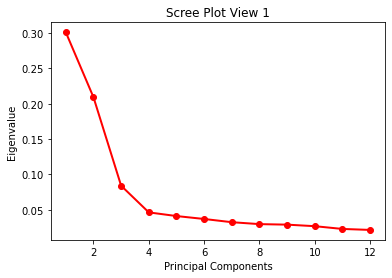

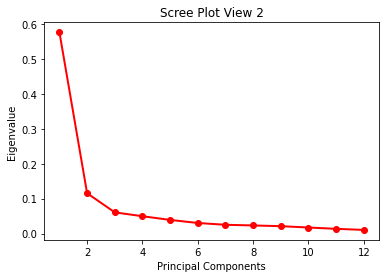

<Figure size 432x288 with 0 Axes>

In [89]:
def scree_plot(n,V,name):
    U, S, V = np.linalg.svd(V)
    eigvals = S**2 / np.sum(S**2)
    eigval_terms = np.arange(n) + 1
    plt.plot(eigval_terms, eigvals[0:n], 'ro-', linewidth=2)
    plt.title('Scree Plot '+ name)
    plt.xlabel('Principal Components')
    plt.ylabel('Eigenvalue')
    plt.figure()

scree_plot(12,V1,'View 1')
scree_plot(12,V2,'View 2')

#It seems as though both inital ranks can be set to 3

In [90]:
#Fitting JIVE

ajive1 = AJIVE(init_signal_ranks= [2,2])
ajive1.fit(blocks=[V1,V1])

ajive2 = AJIVE(init_signal_ranks= [2,2])
ajive2.fit(blocks=[V1,V2])



AJIVE, joint rank: 1, block 0 indiv rank: 1, block 1 indiv rank: 1

In [166]:
blocks2[0]['noise'].shape == blocks2[0]['joint'].shape

True

In [202]:
ajiv_test = AJIVE(init_signal_ranks = [2,2], n_wedin_samples=6)
#ajiv_test.fit(blocks = [V1,V1])

AssertionError: 

In [203]:
ajiv_test.n_wedin_samples


6

In [127]:
#blocks = ajiv_test.get_full_block_estimates()
np.sum(np.sum(blocks[0]['individual'] == 0)) > np.sum(np.sum(blocks[0]['individual'] != 0)) 

True

## Output Structure

The get_full_block_estimates() function returns n dictionaries where n is the number of views that fitted. Each dictionary has a joint, individual, and noise matrix taken from the JIVE decomposition


In [93]:
blocks1 = ajive1.get_full_block_estimates()
blocks2 = ajive2.get_full_block_estimates()


## Heatmap Visualization

Here we are using heatmaps to visualize the decomposition of our views. As we can see when we use two of the same views there is no Individualized Variation displayed. When we create two different views, the algorithm creates new decompositions that can be seen two cells below

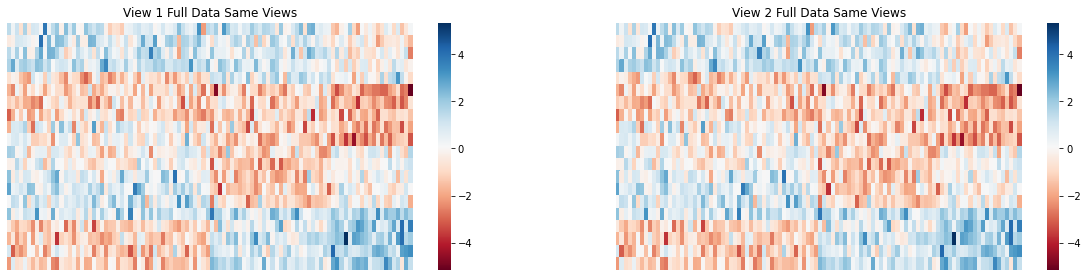

<Figure size 1440x720 with 0 Axes>

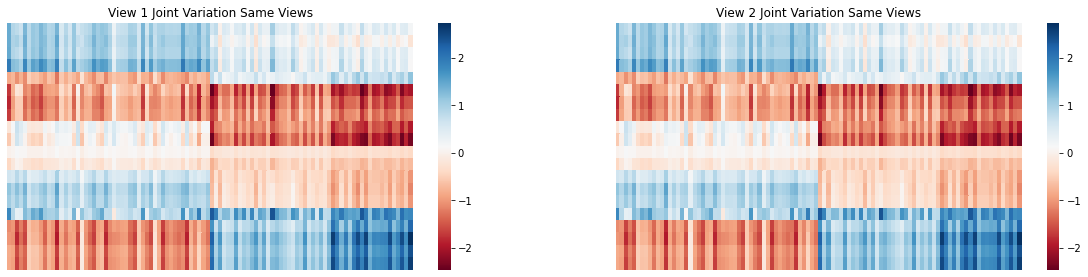

<Figure size 1440x720 with 0 Axes>

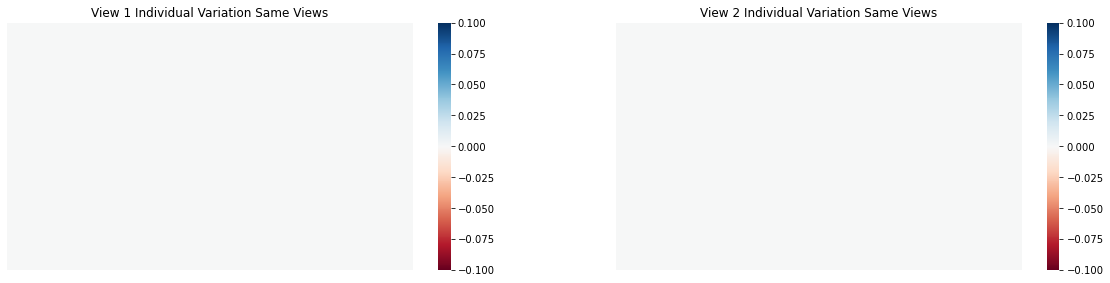

<Figure size 1440x720 with 0 Axes>

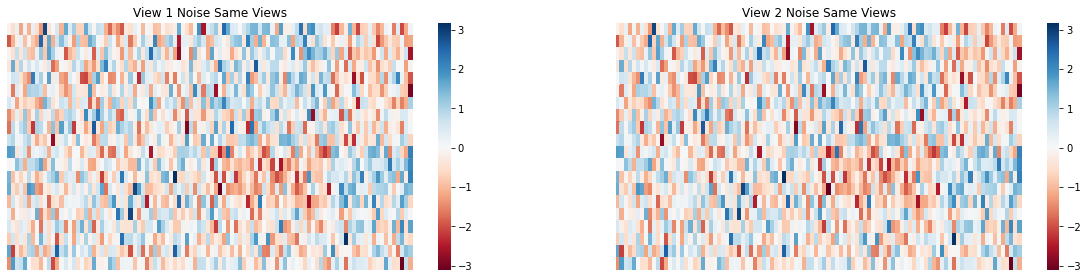

<Figure size 1440x720 with 0 Axes>

In [95]:
def heatmaps(string,inp):
    plt.figure(figsize=(20,10))
    plt.subplot(2,2,1)
    sns.heatmap(inp[0], xticklabels = False, yticklabels = False, cmap = 'RdBu')
    plt.title('View 1 ' + string)
    plt.subplot(2,2,2)
    sns.heatmap(inp[1], xticklabels = False, yticklabels = False, cmap = 'RdBu')
    plt.title('View 2 ' + string)
    plt.figure(figsize=(20,10))

heatmaps("Full Data Same Views", Views_1)

Joint = [blocks1[0]['joint'],blocks1[1]['joint']]
heatmaps("Joint Variation Same Views", Joint)

Individual = [blocks1[0]['individual'],blocks1[1]['individual']]
heatmaps("Individual Variation Same Views", Individual)

Noise = [blocks1[0]['noise'],blocks1[1]['noise']]
heatmaps("Noise Same Views", Noise)

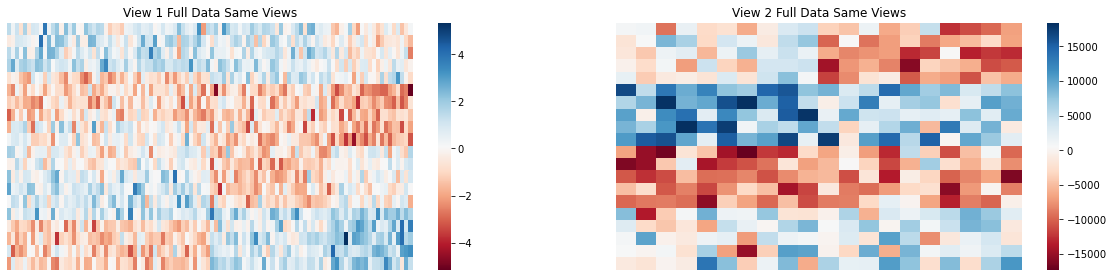

<Figure size 1440x720 with 0 Axes>

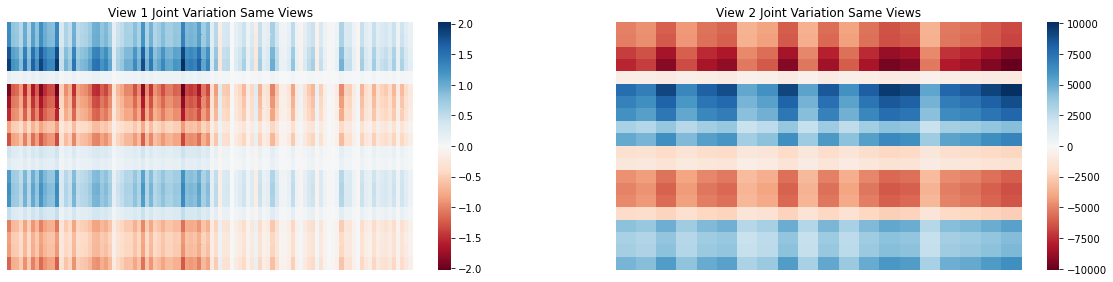

<Figure size 1440x720 with 0 Axes>

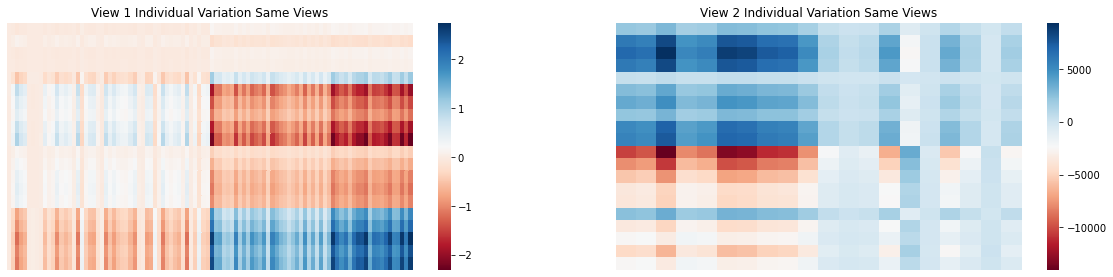

<Figure size 1440x720 with 0 Axes>

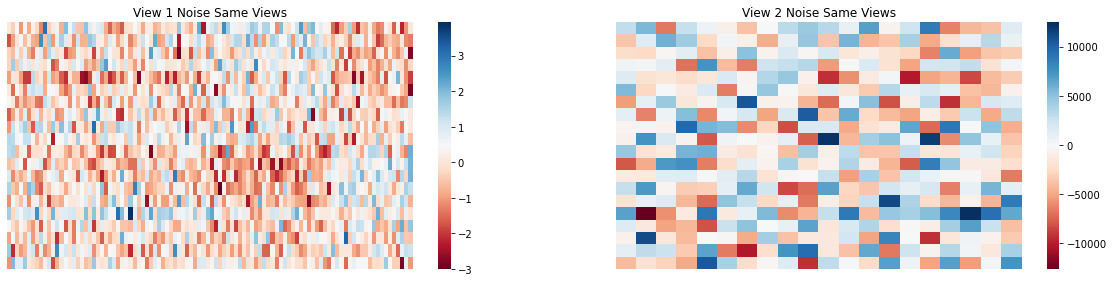

<Figure size 1440x720 with 0 Axes>

In [96]:
heatmaps("Full Data Same Views", Views_2)

Joint = [blocks2[0]['joint'],blocks2[1]['joint']]
heatmaps("Joint Variation Same Views", Joint)

Individual = [blocks2[0]['individual'],blocks2[1]['individual']]
heatmaps("Individual Variation Same Views", Individual)

Noise = [blocks2[0]['noise'],blocks2[1]['noise']]
heatmaps("Noise Same Views", Noise)

In [26]:
p = []
for i in np.arange(100):
    j = np.sum(blocks1[0]['individual'][i] == blocks1[1]['individual'][i])
    print(j == 20)
    


True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
